# EE675A: Assignment 3A
**Name**: Dhruv                               </br>
**Roll No.**: 210338


# Cliff Walking

Through this gridworld exercise we will compare Sarsa and Q-learning algorithms, highlighting the difference between them. Consider the Cliff World shown in the assignment. This is a standard undiscounted, episodic task, with start and goal states, and the usual actions causing movement up, down, right, and left. Reward is −1 on all transitions except those into the the region marked “The Cliff.” Stepping into this region incurs a reward of −100 and sends the agent instantly back to the start. There are totally 48 states numbered from 0 to 47



In [103]:
!pip install pygame
!pip install "gymnasium[toy-text]"

In [104]:
# Import
%matplotlib inline
import gymnasium as gym
import itertools
import matplotlib
import numpy as np
import pandas as pd
import sys
import time
from matplotlib import pyplot as plt
from collections import defaultdict
matplotlib.style.use('ggplot')

In [105]:
# Create environment
# change render mode to 'ansi' to run the algorithm fast
env = gym.make('CliffWalking-v0', render_mode='human')
env.reset()
env.render()
time.sleep(0.1)

In [106]:
env.step(1)
# state, action, terminated?, truncated?, info

(36, -100, False, False, {'prob': 1.0})

In [107]:
# Allowed Actions
# 0 => UP
# 1 => Right
# 2 => Down
# 3 => Left

# Let us take a few actions and get familiar with the environment
print('We started here')
env.reset()
env.render()

# Let us take up first
print('Let us take UP action')
env.step(0)
env.render()

# Now lets take another UP
print('Another UP action')
env.step(0)
env.render()

# Now lets take two rights
print('Two Right actions')
env.step(1)
env.step(1)
env.render()

# Now one left
print('One Left action')
env.step(3)
env.render()

env.close()

We started here
Let us take UP action
Another UP action
Two Right actions
One Left action


In [108]:
# A helper function for plotting the comparision graphs between two or more algorithms.
# You need not understand this code.
# Just look at the next cell to understand how to use it.

def plot_episode_reward(a, stats, smoothing_window=10, noshow=False):
    # Plot the episode reward over time
    fig2 = plt.figure(figsize=(7,3))
    for stat in stats:
        rewards_smoothed = pd.Series(stat).rolling(smoothing_window, min_periods=smoothing_window).mean()
        plt.plot(rewards_smoothed)
    plt.xlabel("Episode")
    plt.ylabel("Episode Reward (Smoothed)")
    plt.title("Episode Reward over Time (Smoothed over window size {})".format(smoothing_window))
    plt.legend(a)
    if noshow:
        plt.close(fig2)
    else:
        plt.show(fig2)

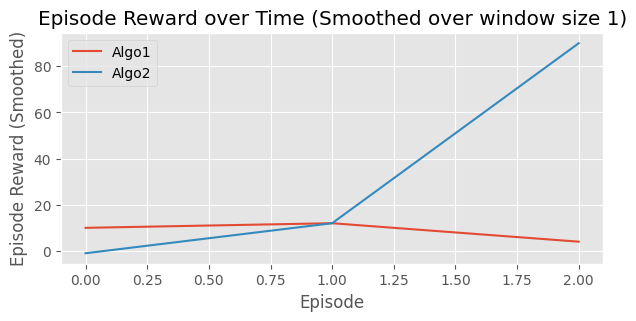

In [109]:
# Demo for using Plotting helper function
# Here we are comparing two algorithms which were run for 3 episodes each.

stats_algo1= [10,12,4]    #The return obtained in each episode for Algo1
stats_algo2= [-1,12,90]    #The return obtained in each episode for Algo2

#Plotting the comparision
#Here the last argument is to smoothen the plot. Use higher values such as 10 for smooth plots.

plot_episode_reward(['Algo1','Algo2'],[stats_algo1,stats_algo2],smoothing_window=1)

### Epsilon-greedy policy from Q-function and epsilon

Helper function to create epsilon-greedy policy based on a given Q-function and epsilon.

In [110]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.

    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action. Float between 0 and 1.
        nA: Number of actions in the environment.

    Returns:
        A function that takes the state/observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.

    """
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA

        if type(observation) is tuple:
            best_action = np.argmax(Q[observation[0]])
        else:
            best_action = np.argmax(Q[observation])

        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

In [111]:
# How to use make_epsilon-greedy_policy function
# consider two states s1, s2 and 3 actions {0,1,2} in each state

Q={'s1':[0.5, 2, 3], 's2':[-0.1, 4 , 3]}  # A sample Q-function Q(s,a) for each state-action pair

# For this example it is clear that for state s1, action 2 is the greedy action.
# For state s2, action 1 is the greedy action

"""
If we want an epsilon greedy policy with epsilon=0.3, then the best action
should get a probility = 0.7 + 0.3/3 = 0.8
other action with probability = 0.3/3 = 0.1

"""

# Let us verify this using our make_epsilon-greedy_policy function

policy_fn = make_epsilon_greedy_policy(Q, epsilon=0.3, nA=3)

print("The epsilon-greedy policy at state s1 is ", policy_fn('s1'))
print("The epsilon-greedy policy at state s2 is ", policy_fn('s2'))

The epsilon-greedy policy at state s1 is  [0.1 0.1 0.8]
The epsilon-greedy policy at state s2 is  [0.1 0.8 0.1]


***

## Q1.1 SARSA algorithm

Implement the SARSA algorithm using the following function template that retunts a tuple containing the optimal action value function and training statistics (array of cumulatetive rewards at each episode) **[8 Marks]**

In [112]:
def create_epsilon_greedy_policy(q_values, epsilon, n_actions):
    """
    Generates an epsilon-greedy policy function.

    Args:
        q_values: Current estimates of action values.
        epsilon: Probability of choosing a random action.
        n_actions: Total number of possible actions.

    Returns:
        A function that takes a state and returns action probabilities.
    """
    def policy(state):
        probs = np.ones(n_actions, dtype=float) * epsilon / n_actions
        best_action = np.argmax(q_values[state])
        probs[best_action] += (1.0 - epsilon)
        return probs
    return policy

In [113]:
def run_sarsa_episode(env, q_values, policy, discount_factor, alpha):
    """
    Runs a single episode of the SARSA algorithm.

    Args:
        env: The environment to interact with.
        q_values: The current action-value function.
        policy: The policy function to use for action selection.
        discount_factor: Discount factor (gamma).
        alpha: Learning rate.

    Returns:
        The updated action-value function (Q) and the total reward of the episode.
    """
    current_state, _ = env.reset()
    action_probs = policy(current_state)
    current_action = np.random.choice(np.arange(len(action_probs)), p=action_probs)

    total_reward = 0
    for _ in range(500):  # Safety limit
        next_state, reward, game_over, _, _ = env.step(current_action)
        next_action_probs = policy(next_state)
        next_action = np.random.choice(np.arange(len(next_action_probs)), p=next_action_probs)

        future_value = q_values[next_state][next_action] if not game_over else 0
        predicted_value = q_values[current_state][current_action]
        target_value = reward + discount_factor * future_value
        update = alpha * (target_value - predicted_value)
        q_values[current_state][current_action] += update

        current_state = next_state
        current_action = next_action
        total_reward += reward

        if game_over:
            break
    return q_values, total_reward


In [114]:
def sarsa(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1):
    """
    SARSA algorithm: Finds the optimal epsilon-greedy policy.

    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.

    Returns:
        A tuple (Q, stats).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is an EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    episode_rewards = np.zeros(num_episodes)
    policy = create_epsilon_greedy_policy(Q, epsilon, env.action_space.n)

    for episode in range(num_episodes):
        Q, total_reward = run_sarsa_episode(env, Q, policy, discount_factor, alpha)
        episode_rewards[episode] = total_reward

    return Q, episode_rewards

In [115]:
# Create environment
# change render mode to 'rgb_array' to run the algorithm without graphical display
env = gym.make('CliffWalking-v0', render_mode='rgb_array')
env.reset()
# env.render() # No longer needed as it's not human-readable
# time.sleep(0.1)

(36, {'prob': 1})

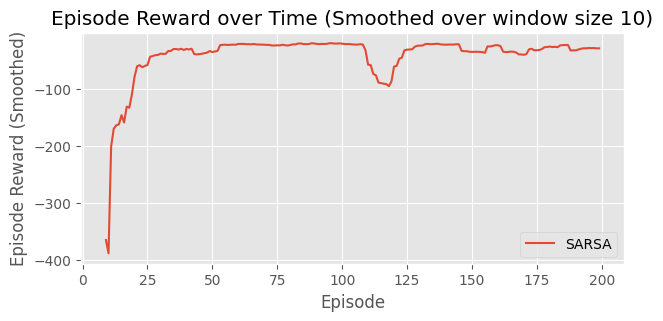

In [116]:
episodes = 200
Q_sarsa, stats_sarsa = sarsa(env, episodes, epsilon=0.1)
plot_episode_reward(['SARSA'],[stats_sarsa])

## Q1.2 Q-Learning algorithm

Implement the Q-Learning algorithm using the following function template that retunts a tuple containing the optimal action value function and training statistics (array of cumulatetive rewards at each episode) **[8 Marks]**

In [117]:
def create_epsilon_greedy_policy(q_values, epsilon, n_actions):
    """
    Generates an epsilon-greedy policy function.

    Args:
        q_values: Current estimates of action values.
        epsilon: Probability of choosing a random action.
        n_actions: Total number of possible actions.

    Returns:
        A function that takes a state and returns action probabilities.
    """
    def policy(state):
        probs = np.ones(n_actions, dtype=float) * epsilon / n_actions
        best_action = np.argmax(q_values[state])
        probs[best_action] += (1.0 - epsilon)
        return probs
    return policy

def run_q_learning_episode(env, q_values, policy, discount_factor, alpha):
    """
    Runs a single episode of the Q-Learning algorithm.

    Args:
        env: The environment to interact with.
        q_values: The current action-value function.
        policy: The policy function to use for action selection.
        discount_factor: Discount factor (gamma).
        alpha: Learning rate.

    Returns:
        The updated action-value function (Q) and the total reward of the episode.
    """
    current_state, _ = env.reset()
    total_reward = 0
    while True:
        action_probs = policy(current_state)
        current_action = np.random.choice(np.arange(len(action_probs)), p=action_probs)

        next_state, reward, game_over, _, _ = env.step(current_action)
        total_reward += reward

        best_next_action = np.argmax(q_values[next_state])
        future_value = q_values[next_state][best_next_action] if not game_over else 0
        predicted_value = q_values[current_state][current_action]
        target_value = reward + discount_factor * future_value
        update = alpha * (target_value - predicted_value)
        q_values[current_state][current_action] += update

        current_state = next_state

        if game_over:
            break
    return q_values, total_reward

In [118]:
def q_learning(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1):
    """
    Q-Learning algorithm: Finds the optimal greedy policy
    while following an epsilon-greedy policy

    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Chance to sample a random action. Float between 0 and 1.

    Returns:
        A tuple (Q, stats).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is an EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """

    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    episode_rewards = np.zeros(num_episodes)
    policy = create_epsilon_greedy_policy(Q, epsilon, env.action_space.n)

    for episode in range(num_episodes):
        Q, total_reward = run_q_learning_episode(env, Q, policy, discount_factor, alpha)
        episode_rewards[episode] = total_reward

    return Q, episode_rewards

### Comparison and Generating Plots
Plotting the reward over episodes for both SARSA and Q-Learning

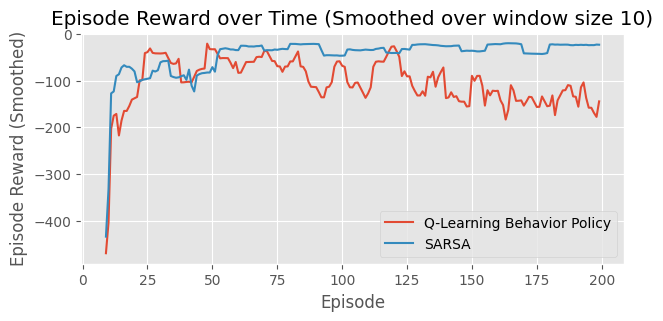

In [119]:
episodes = 200
Q_q, stats_q = q_learning(env, episodes, epsilon=0.2)
Q_sarsa, stats_sarsa = sarsa(env, episodes, epsilon=0.2)
plot_episode_reward(['Q-Learning Behavior Policy','SARSA'],[stats_q,stats_sarsa])

## Before we go on to visualize the policies generated by two TD methods answer the following questions:

#### Q2. Why is Q-learning considered an off-policy control method? **[3 Marks]** <br>
#### Q3. Which algorithm takes a more conservative path? **[1 Marks]** <br>



### Answer:

##2 -

Q-learning is considered an **off-policy control method** because it learns about the **optimal policy** independently of the actions the agent actually takes. While the agent explores the environment using a **behavior policy** (often ε-greedy), Q-learning updates its value estimates towards the **optimal (greedy) policy** by always considering the **best possible action** in the next state, regardless of the action the agent will truly execute.

The key difference in the update rule highlights this:

* **SARSA (on-policy):** Updates its value based on the action the agent *will* take next:
    ```
    Q(s,a) ← Q(s,a) + α[r + γQ(s',a') - Q(s,a)]
    ```
* **Q-learning (off-policy):** Updates its value based on the *best possible* action in the next state:
    ```
    Q(s,a) ← Q(s,a) + α[r + γ max_a' Q(s',a') - Q(s,a)]
    ```

This **decoupling** between the agent's exploration (behavior policy) and the policy being learned (target policy) is the defining characteristic of off-policy algorithms. It allows Q-learning to learn the optimal way to behave even while the agent is actively exploring with potentially suboptimal actions.


##3 -
In the Cliff Walking environment, SARSA exhibits a more cautious behavior, opting for paths that maintain a greater distance from the cliff edge. This is a direct consequence of its **on-policy** nature. SARSA learns the value of the actions dictated by the policy it's currently following, which inherently includes the possibility of random exploratory moves. Given the substantial negative reward for falling off the cliff (-100), SARSA's learning process penalizes actions near the edge, leading it to favor safer, albeit potentially longer, routes to avoid accidental falls due to exploration.

Conversely, **Q-learning**, being an **off-policy** algorithm, learns the optimal action values independent of the agent's exploration strategy. This allows Q-learning to identify the shortest path, which often runs along the precipice of the cliff. However, this optimal path is inherently riskier under a policy that includes exploration. Thus, SARSA's on-policy learning makes it sensitive to the potential dangers of its own exploratory actions, resulting in a more conservative navigation strategy compared to Q-learning's pursuit of the theoretically shortest path.

### Visualizing the policy

In [120]:
# function to visualize policy over the environment
def render_policy(pi, mode='human', close=False):

    cliff_pose = [(3,1),(3,2),(3,3),(3,4),(3,5),(3,6),(3,7),(3,8),(3,9),(3,10)] # cliff states
    for s in range(48):
        position = np.unravel_index(s, (4,12))
        # print(self.s)
        if pi[position] == 0:
            output = " ↑ "
        elif pi[position] == 1:
            output = " → "
        elif pi[position] == 2:
            output = " ↓ "
        elif pi[position] == 3:
            output = " ← "

        if position == (3,11):
            output = " T "
        elif position in cliff_pose:
            output = " G "

        if position[1] == 0:
            output = output.lstrip()
        if position[1] == 12 - 1:
            output = output.rstrip()
            output += "\n"

        print(output, end="")
    print("\n")

In [121]:
# extracting greedy policy from the Q function
pi_sarsa = np.zeros(env.observation_space.n)
pi_q = np.zeros(env.observation_space.n)
for s in range(env.observation_space.n):
    pi_sarsa[s] = np.argmax(Q_sarsa[s])
    pi_q[s] = np.argmax(Q_q[s])

# Instead of env.shape, use env.observation_space.shape or the known shape (4, 12)
pi_sarsa = np.reshape(pi_sarsa, (4, 12))  # Reshape to (4, 12) for CliffWalking-v0
pi_q = np.reshape(pi_q, (4, 12))  # Reshape to (4, 12) for CliffWalking-v0

print('SARSA policy:')
render_policy(pi_sarsa)
print('Q-learning policy:')
render_policy(pi_q)

SARSA policy:
→  →  →  →  →  →  →  →  →  →  →  ↓
↑  ↑  ↑  ↑  ↑  →  →  ↑  →  ↑  →  ↓
↑  ←  ←  ↑  →  ↑  ↑  ↑  →  ←  →  ↓
↑  G  G  G  G  G  G  G  G  G  G  T


Q-learning policy:
←  ↓  ↑  ↓  →  →  →  ←  ↓  →  →  ↓
→  →  →  →  ↓  →  →  →  ↓  →  →  ↓
→  →  →  →  →  →  →  →  →  →  →  ↓
↑  G  G  G  G  G  G  G  G  G  G  T


